In [4]:
# -*- coding: utf-8 -*-
'''
Computa els canvis registrats en el taulell de joc i ho passa al Mòdul Control.
'''
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import time

In [5]:
def mostrarResultat(im,estatPartida,debug=False):
    for d in estatPartida:
        if debug:
            print(d,':',estatPartida[d])
        punts = estatPartida[d][1]
        x,y,w,h = estatPartida[d][0]
        orientacio = estatPartida[d][2]
        margin=20
        if orientacio == 0:
            x1=x-margin
            y1=y+int(h/2)
            x2=x+w
            y2=y+int(h/2)
            im =cv.putText(im,str(punts[0]),(x1,y1), cv.FONT_HERSHEY_SIMPLEX, 1,(0,255,0),2,cv.LINE_AA)
            im =cv.putText(im,str(punts[1]),(x2,y2), cv.FONT_HERSHEY_SIMPLEX, 1,(0,255,0),2,cv.LINE_AA)
        else:
            x1=x+int(w/2)
            y1=y
            x2=x+int(w/2)
            y2=y+h+margin
            im =cv.putText(im,str(punts[0]),(x1,y1), cv.FONT_HERSHEY_SIMPLEX, 1,(255,0,0),2,cv.LINE_AA)
            im =cv.putText(im,str(punts[1]),(x2,y2), cv.FONT_HERSHEY_SIMPLEX, 1,(255,0,0),2,cv.LINE_AA)            
        if debug:
            im =cv.putText(im,str(d),(x+int(w/2),(y+int(h/2))), cv.FONT_HERSHEY_SIMPLEX, 1,(0,0,255),2,cv.LINE_AA)
    im.astype('uint8')
    return im

In [ ]:
def processarFrame(frame, debug=False):
    start = time.time()
    im = frame.copy()
    # Aplicar Threshold per obtenir imatge binaria
    ret,threshold = cv.threshold(frame,127,255,cv.THRESH_BINARY) 
    # Aplicar filtre Gaussia per eliminar el soroll
    threshold = cv.GaussianBlur(threshold, (5,5), 0) 
    
    # Creem imatge 2D per trobar-hi contorns 
    contorns = threshold[:,:,0]
    if debug :
        plt.figure()
        plt.imshow(contorns,'gray')
    # Trobem els contorns presents en la imatge (principalment les fitxes i els punts)
    contours, hierarchy = cv.findContours(contorns,cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # contours -> Llista de contorns (llista de llistes de punts que formen cada contorn)
    # hierarchy ->Llista de relacions entre contorns
    # estructura de hierarchy -> [Next, Previous, First_Child, Parent]
    # el valor de cada camp referencia a un altre contorn
    # si no fa referencia a cap contorn, valor = -1 p.e si un contorn no te cap contorn dins : First_Child = -1
    
    # Creem un diccionari per desar les fitxes amb les seves dades
    dictContorns = {}
    # dictContorns = {idContorn: [cos,punts,orientacio]}
    #                 cos: [x, y, width, height]
    #                 punts: [puntsA, puntsB]
    #                 orientacio: 0 Horitzontal; 1 Vertical
    
    # Per cada contorn c
    for i,c in enumerate(contours):
        pare = hierarchy[0][i,3]
        # Si el contorn actual esta dins d'algun altre (es un punt)
        if pare != -1:
            # registrem les dades de la fitxa a la que pertany el punt a la variable cos
            # cos -> (x,y,width,height)
            cos = cv.boundingRect(contours[pare])
            # registrem les dades del punt actual
            x,y,w,h = cv.boundingRect(contours[i])
            punts=[0,0]
            orientacio=0
            #Comprovem l'orientacio de la fitxa i assignem el punt a un dels costats
            if cos[2] > cos[3]:
                # Horitzontal
                orientacio=0
                if x < cos[0]+int(cos[2]/2):
                    punts=[1,0] # Esquerra
                else:
                    punts=[0,1] # Dreta
            elif cos[2] < cos[3]:
                # Vertical
                orientacio=1
                if y < cos[1]+int(cos[3]/2):
                    punts=[1,0] # Superior
                else:
                    punts=[0,1] # Inferior
            else:
                print('Error!')
                pass          
            
            # Si la fitxa no existeix en el diccionari, la afegim amb totes les dades que hem recollit
            if not str(pare) in dictContorns:
                dictContorns[str(pare)]=[cos,punts,orientacio]
            # Si la fitxa si existeix, modifiquem el camp punts afegint el punt trobat al canto corresponent
            else:               
                dictContorns[str(pare)][1][0]+=punts[0]
                dictContorns[str(pare)][1][1]+=punts[1]
    if debug:
        print('Temps execució: %.3f segons' %(time.time()-start))
    return dictContorns

Temps execució: 0.030 segons
0 : [(46, 365, 169, 87), [3, 3], 0]
7 : [(395, 249, 134, 181), [6, 6], 1]
20 : [(89, 191, 87, 169), [2, 3], 1]
26 : [(333, 90, 171, 115), [2, 1], 0]
30 : [(90, 18, 87, 169), [2, 2], 1]


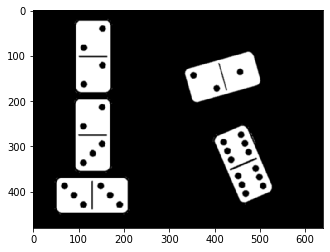

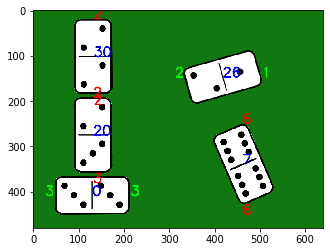

In [6]:
if __name__ == '__main__':
    frame = cv.imread('src/test1fitxa.png')    
    estatPartida = processarFrame(frame,True)
    im=frame.copy()
    debug = True;
    if debug:
        plt.figure()
        plt.imshow(mostrarResultat(im,estatPartida))